In [1]:
from tensorflow.keras.models import Sequential#, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Lambda, Conv2D
from tensorflow.keras.optimizers import Adam

def buildModel():
    #print("building our model")
    model = Sequential()
    model.add(Lambda(lambda x : x/127.5-1.0, input_shape = (66,200,3) ))
    model.add(Conv2D(24, (5, 5), activation = "elu", strides=(2,2)))
    model.add(Conv2D(36, (5, 5), activation = "elu", strides=(2,2)))
    model.add(Conv2D(48, (5, 5), activation = "elu", strides=(2,2)))
    model.add(Conv2D(64, (5, 5), activation = "elu"))
    #model.add(Conv2D(64, (5, 5), activation = "elu"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation='elu'))
    model.summary()
    
    return model

model = buildModel()
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 18, 64)         76864     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [77]:
import tensorflow as tf
import numpy as np
import cv2

def compute_gradcam_regression(model, img_array, angle,
                               last_conv_layer_name="conv2d_2"):
    eps = 1e-8

    gradModel = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ],
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        convOutputs, prediction = gradModel(inputs)
        STRAIGHT_THRESH = 0.1
        # steering-conditioned target
        if angle > STRAIGHT_THRESH:
            loss = prediction
        elif angle < -STRAIGHT_THRESH:
            loss = -prediction
        else:
            loss = tf.math.abs(prediction)

    grads = tape.gradient(loss, convOutputs)

    # remove batch dimension
    convOutputs = convOutputs[0]
    grads = grads[0]

    # channel importance weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = tf.reduce_sum(weights * convOutputs, axis=-1)

    # optional: keep only positive influence
    #cam = tf.nn.relu(cam)

    heatmap = cv2.resize(
        cam.numpy(),
        (img_array.shape[2], img_array.shape[1])
    )

    #heatmap = (heatmap - heatmap.min()) / (heatmap.max() + eps)
    #heatmap = (heatmap * 255).astype("uint8")

    return heatmap

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

def compute_gradcam(model, img_array, last_conv_layer_name="conv2d_3"):
    eps=1e-8
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output,
            model.output])
    
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[0]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)   
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

In [3]:
def preprocess(image):
    return cv2.resize(image, (200, 66), cv2.INTER_AREA)

def image_process(image):
    image = np.asarray(image)       # from PIL image to numpy array
    image = preprocess(image)       # apply the preprocessing
    image = np.array([image])       # the model expects 4D array
    return image

In [57]:
def resize_heatmap_to_image(heatmap, original_image):
    """
    Resize a Grad-CAM heatmap to match the original image size.

    Args:
        heatmap: 2D numpy array, shape = (conv_height, conv_width)
        original_image: 3D numpy array, shape = (H, W, C)

    Returns:
        heatmap_resized: 2D numpy array, shape = (H, W)
    """
    H, W = original_image.shape[:2]

    # Resize heatmap to match original image
    heatmap_resized = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_LINEAR)

    # Optional: normalize to 0-1
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min() + 1e-8)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    return heatmap_resized

In [ ]:
def overlay_heatmap(img, heatmap, alpha=0.5):
    """
    img: Original image (Numpy array)
    heatmap: 2D heatmap (Numpy array, values 0 to 1)
    alpha: Transparency (0.5 means 50% image, 50% heatmap)
    """
    # 1. Resize heatmap to match original image size
    #heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # 2. Convert heatmap to 0-255 range (uint8)
    heatmap_255 = np.uint8(255 * heatmap)

    # 3. Apply a ColorMap (JET is standard for "hot/cold" visuals)
    heatmap_color = cv2.applyColorMap(heatmap_255, cv2.COLORMAP_JET)
    #print("Original image size: ", img.shape)
    #print("Heatmap image size: ", heatmap_color.shape)
    #sys.stdout.flush() # Forces the print to appear NOW

    # 4. Ensure dtypes match (OpenCV blending needs same type)
    #if img.dtype != np.uint8:
    #    img = np.uint8(img)

    # 4. Blend the two images
    # formula: result = (img * (1-alpha)) + (heatmap * alpha)
    #overlayed_img = cv2.addWeighted(img[0], 1 - alpha, heatmap_color, alpha, 0) # img: shape (1, H, W, Channel)
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0) # img: shape (H, W, Channel)

    return overlayed_img

ERROR! Session/line number was not unique in database. History logging moved to new session 17


In [5]:
from tensorflow.keras.models import load_model

model = load_model("D:\ML\Self Driving Car\self_driving_car\Self-Driving-Car-Python\Self Driving Car\Python with Tensorflow\Best Models/data-003.h5") 	# Directory to load the model


In [78]:
# load the image
import os
from PIL import Image

path = r"D:\ML\Self Driving Car\self_driving_car\Self-Driving-Car-Python\driving_data\Drive SDC"         # Destination/path to which all the current images will be saved 
heatmap_path = r"D:\ML\Self Driving Car\self_driving_car\Self-Driving-Car-Python\driving_data\Drive_SDC_heatmap_regression_3conv_again"         # Destination/path to which all the current images will be saved 

for num, imageName in enumerate(os.listdir(path)):
    num = num + 1
    imageName = 'Wasil'+ str(num) + '.png'      # Name of the images.
    image_ori = np.array(Image.open(os.path.join(path, imageName)))  # Directory to load the image
    image = image_process(image_ori)      # Preprocessing the image.

    steering_angle = float(model.predict(image, batch_size=1))

    # computer gradient cam heatmap
    heatmap = compute_gradcam_regression(model, image, steering_angle) # in numpy array format.
    heatmap_resized = resize_heatmap_to_image(heatmap, image_ori)
    #print(image.shape, heatmap.shape)
    result = overlay_heatmap(image_ori, heatmap_resized)
    #result = overlay_heatmap(image, heatmap)

    imageName = 'sdc_heatmap_original_'+ str(num) + '.png'
    cv2.imwrite(os.path.join(heatmap_path, imageName), result)

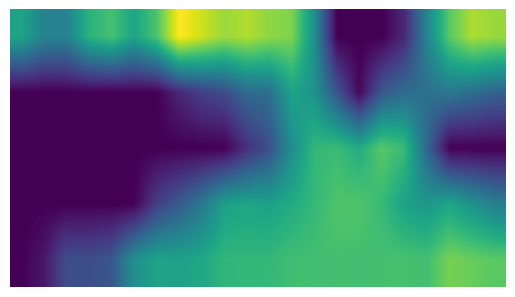

In [49]:
import matplotlib.pyplot as plt

plt.imshow(heatmap_resized)
plt.axis('off')   # hide axes
plt.show()

In [14]:
heatmap.shape

TensorShape([1, 18, 64])